### Notebook to check oral androgen deprivation therapy data

A notebook using [English Prescribing Data](https://www.nhsbsa.nhs.uk/prescription-data/prescribing-data/english-prescribing-data-epd) to compare codelists used by OpenPrescribing measure against study findings.

- [Imports](#IMPORTS)
- [Standard functions](#FUNCTIONS)
- [OpenPrescribing BNF codes](#OPBNF)
- [Item / quantity plots](#CHARTS)
- [Injections of different durations](#INJDURATION)

<a id='IMPORTS'></a>
### Imports
Import libraries required for analysis

In [137]:
#import libraries required for analysis
from ebmdatalab import bq
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

#set to display all rows in data
#pd.set_option('display.max_rows', None)

<a id='FUNCTIONS'></a>
### Standard functions
Setup standard functions

In [116]:
def plot(df, column_to_plot, chart_title, y_label, y_min='default', y_max='default', lockdownline=False):
    ax = df.groupby(["month"])[column_to_plot].sum().plot(kind='line', title=chart_title)
    plt.xticks(rotation=90);
    plt.ylabel(y_label);
    if (y_min!='default'):
        plt.ylim((y_min, y_max));
    else:
        y_max=df[column_to_plot].max() * 1.05
    if (lockdownline):
        plt.vlines(x=[pd.to_datetime("2020-03-23")], ymin=0, ymax=int(y_max), colors="red", ls="--", label="Start of restrictions");
    plt.grid();

<a id='OPBNF'></a>
### OpenPrescribing BNF codes
Get [English Prescribing Data](https://www.nhsbsa.nhs.uk/prescription-data/prescribing-data/english-prescribing-data-epd) for monthly items and quantity for BNF codes from codelists:
- [Oral ADT](https://www.opencodelists.org/codelist/user/agleman/oral-adt-prostate-ca-dmd/1e2a36a0/)
- [Injectable ADT](https://www.opencodelists.org/codelist/user/agleman/adt-injectable-dmd/20f9318d/)


In [144]:
#OpenPrescribing BNF codes
sql = '''
SELECT
     CAST(month AS DATE) AS month,
     SUM (CASE WHEN bnf_code IN ("0803042A0AAAAAA", "0803042A0AAABAB", "0803042A0AAACAC", "0803042A0AAADAD", "0803042A0BBAAAA",
                                 "0803042A0BBABAB", "0803042E0AAAAAA", "0803042E0AAABAB", "0803042E0AAADAD", "0803042E0AAAEAE", 
                                 "0803042E0AAAFAF", "0803042E0AAAHAH", "0803042E0AAAIAI", "0803042E0BBAAAA", "0803042E0BBABAB", 
                                 "0803042H0AAAAAA", "0803042H0BBAAAA", "0803042H0BCAAAA")  THEN items ELSE 0 END) as OralADTitems,
     SUM (CASE WHEN bnf_code IN ("0803042A0AAAAAA", "0803042A0AAABAB", "0803042A0AAACAC", "0803042A0AAADAD", "0803042A0BBAAAA",
                                 "0803042A0BBABAB", "0803042E0AAAAAA", "0803042E0AAABAB", "0803042E0AAADAD", "0803042E0AAAEAE", 
                                 "0803042E0AAAFAF", "0803042E0AAAHAH", "0803042E0AAAIAI", "0803042E0BBAAAA", "0803042E0BBABAB", 
                                 "0803042H0AAAAAA", "0803042H0BBAAAA", "0803042H0BCAAAA")  THEN quantity ELSE 0 END) as OralADTqty,
     SUM (CASE WHEN bnf_code IN ("0803042B0AAAAAA", "0803042B0BBAAAA", "0803042K0AAAAAA", "0803042K0AAABAB", "0803042K0BBAAAA", 
                                 "0803042K0BBABAB", "0803042K0BCAAAA", "0803042N0AAAAAA", "0803042N0AAABAB", "0803042N0AAACAC", 
                                 "0803042N0AAADAD", "0803042N0AAAEAE", "0803042N0AAAFAF", "0803042N0BBAAAA", "0803042N0BBABAB", 
                                 "0803042N0BBACAC", "0803042N0BBADAD", "0803042N0BCAAAA", "0803042N0BCABAE", "0803042N0BDAAAF", 
                                 "0803042P0AAAAAA", "0803042P0AAABAB", "0803042P0BBAAAA", "0803042P0BCAAAB", "0803042R0AAAAAA", 
                                 "0803042R0AAABAB", "0803042R0BBAAAA", "0803042R0BBABAB", "0803042S0AAABAB", "0803042S0BCAAAB", 
                                 "0803042W0AAAAAA", "0803042W0BBAAAA")  THEN items ELSE 0 END) as InjADTitems,
     SUM (CASE WHEN bnf_code IN ("0803042B0AAAAAA", "0803042B0BBAAAA", "0803042K0AAAAAA", "0803042K0AAABAB", "0803042K0BBAAAA", 
                                 "0803042K0BBABAB", "0803042K0BCAAAA", "0803042N0AAAAAA", "0803042N0AAABAB", "0803042N0AAACAC", 
                                 "0803042N0AAADAD", "0803042N0AAAEAE", "0803042N0AAAFAF", "0803042N0BBAAAA", "0803042N0BBABAB", 
                                 "0803042N0BBACAC", "0803042N0BBADAD", "0803042N0BCAAAA", "0803042N0BCABAE", "0803042N0BDAAAF", 
                                 "0803042P0AAAAAA", "0803042P0AAABAB", "0803042P0BBAAAA", "0803042P0BCAAAB", "0803042R0AAAAAA", 
                                 "0803042R0AAABAB", "0803042R0BBAAAA", "0803042R0BBABAB", "0803042S0AAABAB", "0803042S0BCAAAB", 
                                 "0803042W0AAAAAA", "0803042W0BBAAAA")  THEN quantity ELSE 0 END) as InjADTqty,
 FROM hscic.normalised_prescribing
 WHERE month >= '2015-01-01'
 GROUP BY month
 ORDER BY month'''

OP_DF = bq.cached_read(sql, csv_path=os.path.join('../..','data','OPADT.csv'))

Downloading: 100%|██████████| 92/92 [00:00<00:00, 415.95rows/s]


In [145]:
OP_DF.dtypes

month           datetime64[ns]
OralADTitems             int64
OralADTqty             float64
InjADTitems              int64
InjADTqty              float64
dtype: object

In [146]:
OP_DF['OralADTqty_per_item']=OP_DF['OralADTqty']/OP_DF['OralADTitems']
OP_DF['InjADTqty_per_item']=OP_DF['InjADTqty']/OP_DF['InjADTitems']
OP_DF

,month,OralADTitems,OralADTqty,InjADTitems,InjADTqty,OralADTqty_per_item,InjADTqty_per_item
0,2015-01-01,23465,754252.0,38103,38842.0,32.143703,1.019395
1,2015-02-01,21644,695207.0,33840,34441.0,32.120079,1.017760
2,2015-03-01,24037,764385.0,37629,38299.0,31.800349,1.017805
3,2015-04-01,23155,740084.0,37165,37770.0,31.962168,1.016279
4,2015-05-01,22783,726911.0,36073,36723.0,31.905851,1.018019
5,2015-06-01,23568,753677.0,37364,38050.0,31.978827,1.018360
6,2015-07-01,24730,786592.0,38611,39333.0,31.807198,1.018699
7,2015-08-01,22533,712599.0,35346,35984.0,31.624684,1.018050
8,2015-09-01,23777,753829.0,38084,38811.0,31.704126,1.019089
9,2015-10-01,23962,756810.0,37277,37993.0,31.583758,1.019208


<a id='CHARTS'></a>
### Item/quantity plots

Generate plots from data in above
1. Injectable ADT items dispensed per month - from English Prescribing Dataset
2. Injectable ADT quantity dispensed per month - from English Prescribing Dataset
3. Injectable ADT quantity per item dispensed per month - from English Prescribing Dataset
4. Oral ADT items dispensed per month - from English Prescribing Dataset
5. Oral ADT quantity dispensed per month - from English Prescribing Dataset
6. Oral ADT quantity per item dispensed per month - from English Prescribing Dataset

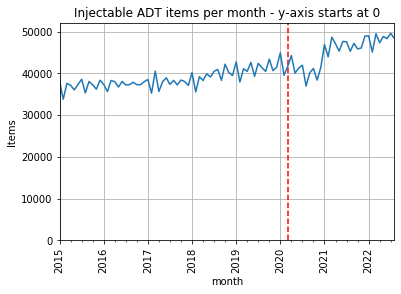

In [147]:
plot(
    df=OP_DF, 
    column_to_plot='InjADTitems', 
    chart_title="Injectable ADT items per month - y-axis starts at 0", 
    y_label='Items', 
    y_min=0, 
    y_max=OP_DF['InjADTitems'].max() * 1.05, 
    lockdownline=True
)

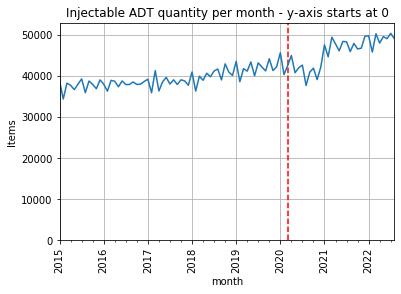

In [148]:
plot(
    df=OP_DF, 
    column_to_plot='InjADTqty', 
    chart_title="Injectable ADT quantity per month - y-axis starts at 0", 
    y_label='Items', 
    y_min=0, 
    y_max=OP_DF['InjADTqty'].max() * 1.05, 
    lockdownline=True
)

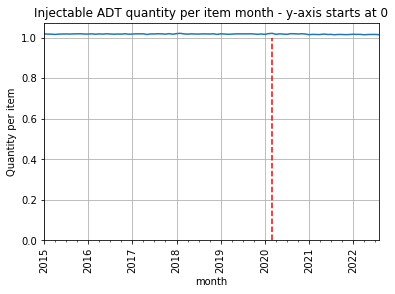

In [150]:
plot(
    df=OP_DF, 
    column_to_plot='InjADTqty_per_item', 
    chart_title="Injectable ADT quantity per item month - y-axis starts at 0", 
    y_label='Quantity per item', 
    y_min=0, 
    y_max=OP_DF['InjADTqty_per_item'].max() * 1.05, 
    lockdownline=True
)

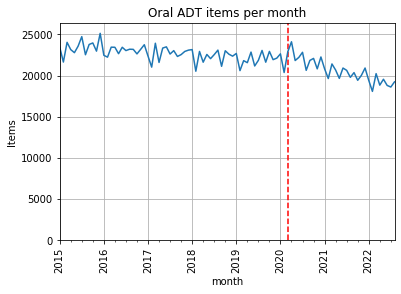

In [151]:
plot(
    df=OP_DF, 
    column_to_plot='OralADTitems', 
    chart_title="Oral ADT items per month", 
    y_label='Items', 
    y_min=0, 
    y_max=OP_DF['OralADTitems'].max() * 1.05, 
    lockdownline=True
)

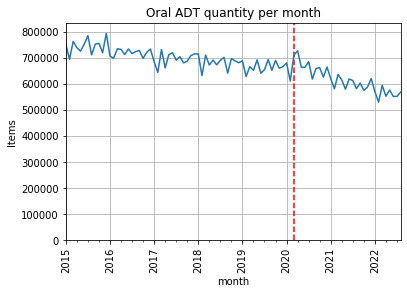

In [152]:
plot(
    df=OP_DF, 
    column_to_plot='OralADTqty', 
    chart_title="Oral ADT quantity per month", 
    y_label='Items', 
    y_min=0, 
    y_max=OP_DF['OralADTqty'].max() * 1.05, 
    lockdownline=True
)

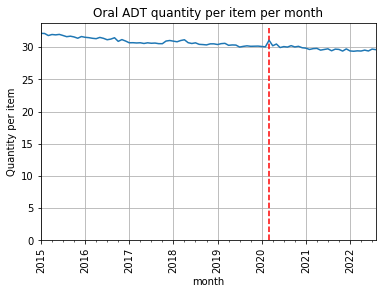

In [153]:
plot(
    df=OP_DF, 
    column_to_plot='OralADTqty_per_item', 
    chart_title="Oral ADT quantity per item per month", 
    y_label='Quantity per item', 
    y_min=0, 
    y_max=OP_DF['OralADTqty_per_item'].max() * 1.05, 
    lockdownline=True
)

<a id='INJDURATION'></a>
### 1 month / 3 month / 6 month injections

Generate plots from data in above
1. Oral ADT items dispensed per month - from English Prescribing Dataset
2. Oral ADT quantity dispensed per month - from English Prescribing Dataset
3. Injectable ADT items dispensed per month - from English Prescribing Dataset
4. Injectable ADT quantity dispensed per month - from English Prescribing Dataset

In [156]:
#OpenPrescribing BNF codes
sql = '''
SELECT
     CAST(month AS DATE) AS month,
     SUM (CASE WHEN bnf_code IN ("0803042K0AAAAAA", "0803042K0BBAAAA", "0803042K0BCAAAA", "0803042N0AAAAAA", "0803042N0AAACAC", 
                                 "0803042N0BBAAAA", "0803042N0BBACAC", "0803042N0BCAAAA", "0803042P0AAAAAA", "0803042P0AAABAB", 
                                 "0803042P0BBAAAA", "0803042P0BCAAAB")  THEN items ELSE 0 END) as monthly,
     SUM (CASE WHEN bnf_code IN ("0803042K0AAABAB", "0803042K0BBABAB", "0803042N0AAABAB", "0803042N0AAADAD", "0803042N0AAAEAE", 
                                 "0803042N0AAAFAF", "0803042N0BBABAB", "0803042N0BBADAD", "0803042N0BCABAE", "0803042N0BDAAAF", 
                                 "0803042P0AAACAC", "0803042P0BBABAC", "0803042S0AAACAC", "0803042W0BBAAAA", "0803042W0AAAAAA")  THEN items ELSE 0 END) as three_monthly,
     SUM (CASE WHEN bnf_code IN ("0803042S0AAABAB", "0803042S0BCAAAB")  THEN items ELSE 0 END) as six_monthly,
 FROM hscic.normalised_prescribing
 WHERE month >= '2015-01-01'
 GROUP BY month
 ORDER BY month'''

OP_duration = bq.cached_read(sql, csv_path=os.path.join('../..','data','OPinjduration.csv'))
OP_duration

Downloading: 100%|██████████| 92/92 [00:00<00:00, 442.11rows/s]


,month,monthly,three_monthly,six_monthly
0,2015-01-01,10808,29577,499
1,2015-02-01,9516,26259,449
2,2015-03-01,10571,29243,557
3,2015-04-01,10455,28749,553
4,2015-05-01,10272,27888,557
5,2015-06-01,10617,28759,567
6,2015-07-01,10857,29945,623
7,2015-08-01,10121,27179,570
8,2015-09-01,10686,29527,647
9,2015-10-01,10598,28710,654


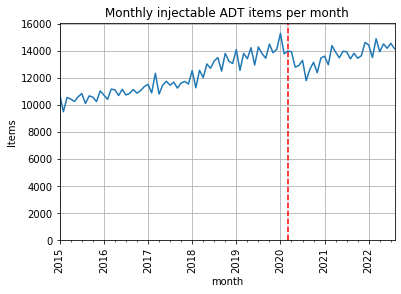

In [127]:
plot(
    df=OP_duration, 
    column_to_plot='monthly', 
    chart_title="Monthly injectable ADT items per month", 
    y_label='Items', 
    y_min=0, 
    y_max=OP_duration['monthly'].max() * 1.05, 
    lockdownline=True
)

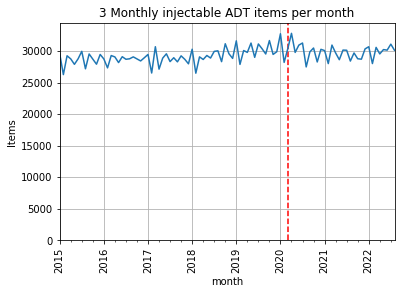

In [128]:
plot(
    df=OP_duration, 
    column_to_plot='three_monthly', 
    chart_title="3 Monthly injectable ADT items per month", 
    y_label='Items', 
    y_min=0, 
    y_max=OP_duration['three_monthly'].max() * 1.05, 
    lockdownline=True
)

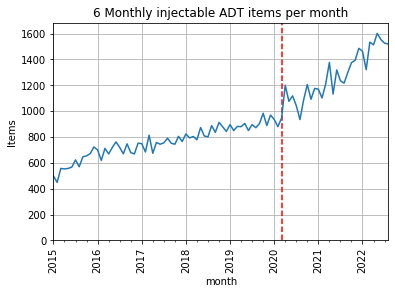

In [129]:
plot(
    df=OP_duration, 
    column_to_plot='six_monthly', 
    chart_title="6 Monthly injectable ADT items per month", 
    y_label='Items', 
    y_min=0, 
    y_max=OP_duration['six_monthly'].max() * 1.05, 
    lockdownline=True
)

In [130]:
OP_duration['sixm_normalised']=OP_duration['six_monthly']*6
OP_duration['threem_normalised']=OP_duration['three_monthly']*3
OP_duration['normalised']=OP_duration['monthly']+OP_duration['three_monthly']+OP_duration['six_monthly']

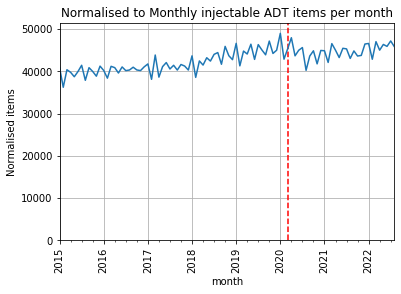

In [131]:
plot(
    df=OP_duration, 
    column_to_plot='normalised', 
    chart_title="Normalised to Monthly injectable ADT items per month", 
    y_label='Normalised items', 
    y_min=0, 
    y_max=OP_duration['normalised'].max() * 1.05, 
    lockdownline=True
)